In [22]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

import imgaug.augmenters as iaa

from astrodet import astrodet as toolkit
from PIL import Image, ImageEnhance
from astropy.visualization import make_lupton_rgb
from astrodet.detectron import plot_stretch_Q
from detectron2.utils.file_io import PathManager
from iopath.common.file_io import file_lock

import logging
logger = logging.getLogger(__name__)
import shutil
import json

from detectron2.structures import BoxMode
from astropy.io import fits
import glob

In [2]:
# Print the versions to test the imports and so we know what works
print(detectron2.__version__)
print(np.__version__)
print(cv2.__version__)

0.6
1.20.3
4.5.3


In [3]:
# Prettify the plotting
from astrodet.astrodet import set_mpl_style
set_mpl_style()

### First, get some HSC data from training_data.ipynb

### Register HSC training data

The file metadata for each dataset is specified with the `filesnames_dict`. We will specify the filters first, then populate the filenames in the dataset directory.

For a custom dataset, this dictionary needs to be populated correctly for your data.

In [4]:
dirpath = '/home/shared/hsc/HSC/HSC_DR3/data/' # Path to dataset
output_dir = '/home/shared/hsc/HSC/HSC_DR3/models/'

dataset_names = ['train', 'test', 'val'] 

In [8]:
#this block is for debug purposes, set to -1 to include every sample
sampleNumbers = 100

In [6]:

#Yufeng Jun19 add test here
dataset_names = ['train','test', 'val'] # train
filenames_dict_list = [] # List holding filenames_dict for each dataset

for i, d in enumerate(dataset_names):
    data_path = os.path.join(dirpath, d)

    # Get dataset dict info
    filenames_dict = {}
    filenames_dict['filters'] = ['g', 'r', 'i']

    # Get each unqiue tract-patch in the data directory
    #file = full path name
    files = glob.glob(os.path.join(data_path, '*_scarlet_segmask.fits'))
    if sampleNumbers != -1:
        files = files[:sampleNumbers]
    # s = sample name
    s = [os.path.basename(f).split('_scarlet_segmask.fits')[0] for f in files]
    #print(f'Tract-patch List: {s}')
    for f in filenames_dict['filters']:
        filenames_dict[f] = {}
        # List of image files in the dataset
        #Yufeng dec/21  [Errno 2] No such file or directory: '/home/shared/hsc/test/G-I-8525-4,5-c5_scarlet_img'
        #filenames_dict[f]['img'] = [os.path.join(data_path, f'{f.upper()}-{tract_patch}_scarlet_img.fits') for tract_patch in s]
        #Yufeng jan 18 f.upper() indicates filter, tract_patch[1:] removes the default I band in the front
        filenames_dict[f]['img'] = [os.path.join(data_path, f.upper() + f'{tract_patch[1:]}_scarlet_img.fits') for tract_patch in s]
        # List of mask files in the dataset
        #Yufeng jan 18 all mask files are in the I band
        filenames_dict[f]['mask'] = [os.path.join(data_path, f'{tract_patch}_scarlet_segmask.fits') for tract_patch in s]
        
    filenames_dict_list.append(filenames_dict)

In [70]:
ftrain=glob.glob(os.path.join('/home/shared/hsc/HSC/HSC_DR3/data/train/', '*_scarlet_segmask.fits'))
ftest=glob.glob(os.path.join('/home/shared/hsc/HSC/HSC_DR3/data/test/', '*_scarlet_segmask.fits'))
fval=glob.glob(os.path.join('/home/shared/hsc/HSC/HSC_DR3/data/val/', '*_scarlet_segmask.fits'))
print(len(ftrain),len(ftest),len(fval))

print(len(ftest)/len(ftrain))

11889 2364 2388
0.19883926318445622


In [7]:
#number of total samples
print('# of train sample: ', len(filenames_dict_list[0]['g']['img']))
print('# of test sample: ', len(filenames_dict_list[1]['g']['img']))

# of train sample:  10
# of test sample:  10


In [10]:
garbage_data = []
def get_astro_dicts(filename_dict):
    
    """
    This can needs to be customized to your trianing data format
    
    """
        
    dataset_dicts = []
    filters = list(filename_dict.keys())
    #yufeng april5: why only 1st filter
    f = filename_dict['filters'][0] # Pick the 1st filter for now
    
    # Filename loop
    for idx, (filename_img, filename_mask) in enumerate(zip(filename_dict[f]['img'], filename_dict[f]['mask'])):
        record = {}

        # Open FITS image of first filter (each should have same shape)
        with fits.open(filename_img, memmap=False, lazy_load_hdus=False) as hdul:
            height, width = hdul[0].data.shape
            
        # Open each FITS mask image
        with fits.open(filename_mask, memmap=False, lazy_load_hdus=False) as hdul:
            hdul = hdul[1:]
            sources = len(hdul)
            # Normalize data
            data = [hdu.data for hdu in hdul]
            category_ids = [hdu.header["CAT_ID"] for hdu in hdul]
            ellipse_pars = [hdu.header["ELL_PARM"] for hdu in hdul]
            bbox = [list(map(int, hdu.header["BBOX"].split(','))) for hdu in hdul]
            area = [hdu.header["AREA"] for hdu in hdul]

        # Add image metadata to record (should be the same for each filter)
        for f in filename_dict['filters']:
            record[f"filename_{f.upper()}"] = filename_dict[f]['img'][idx]
        # Assign file_name
        record[f"file_name"] = filename_dict[filename_dict['filters'][0]]['img'][idx]
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []

        # Generate segmentation masks from model
        for i in range(sources):
            image = data[i]
            # Why do we need this?
            if len(image.shape) != 2:
                continue
            height_mask, width_mask = image.shape
            # Create mask from threshold
            mask = data[i]
            # Smooth mask
            #mask = cv2.GaussianBlur(mask, (9,9), 2)
            x,y,w,h = bbox[i] # (x0, y0, w, h)

            # https://github.com/facebookresearch/Detectron/issues/100
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                # contour = [x1, y1, ..., xn, yn]
                contour = contour.flatten()
                if len(contour) > 4:
                    contour[::2] += (x-w//2)
                    contour[1::2] += (y-h//2)
                    segmentation.append(contour.tolist())
            # No valid countors
            if len(segmentation) == 0:
                continue

            # Add to dict
            obj = {
                "bbox": [x-w//2, y-h//2, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i],
                "ellipse_pars": ellipse_pars[i]
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        #img = read_image(record, normalize="lupton", stretch=.8, Q=150, ceil_percentile=99.9995)
        #img0std = np.std(np.trim_zeros(img[:,:,0].flatten()))
        #if img0std > 10:
        #    img1std = np.std(np.trim_zeros(img[:,:,1].flatten()))
        #    if img1std > 10:
        #        img2std = np.std(np.trim_zeros(img[:,:,2].flatten()))
        #        if img2std > 10:
        #            dataset_dicts.append(record)
        #        else:
        #            garbage_data.append(record)
        #    else:
        #        garbage_data.append(record)
        #else:
        #    garbage_data.append(record)
            
    return dataset_dicts

In [73]:
garbage_data = []
def get_astro_dicts_new(filename_dict):
    
    """
    This can needs to be customized to your trianing data format
    
    """
        
    dataset_dicts = []
    filters = list(filename_dict.keys())
    #yufeng april5: why only 1st filter
    f = filename_dict['filters'][0] # Pick the 1st filter for now
    
    # Filename loop
    for idx, (filename_img, filename_mask) in enumerate(zip(filename_dict[f]['img'], filename_dict[f]['mask'])):
        record = {}

        # Open FITS image of first filter (each should have same shape)
        with fits.open(filename_img, memmap=False, lazy_load_hdus=False) as hdul:
            height, width = hdul[0].data.shape
            
        # Open each FITS mask image
        with fits.open(filename_mask, memmap=False, lazy_load_hdus=False) as hdul:
            hdul = hdul[1:]
            sources = len(hdul)
            # Normalize data
            data = [hdu.data for hdu in hdul]
            category_ids = [hdu.header["CAT_ID"] for hdu in hdul]
            ellipse_pars = [hdu.header["ELL_PARM"] for hdu in hdul]
            bbox = [list(map(int, hdu.header["BBOX"].split(','))) for hdu in hdul]
            area = [hdu.header["AREA"] for hdu in hdul]

        # Add image metadata to record (should be the same for each filter)
        for f in filename_dict['filters']:
            record[f"filename_{f.upper()}"] = filename_dict[f]['img'][idx]
        # Assign file_name
        record[f"file_name"] = filename_dict[filename_dict['filters'][0]]['img'][idx]
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []

        # Generate segmentation masks from model
        for i in range(sources):
            image = data[i]
            # Why do we need this?
            if len(image.shape) != 2:
                continue
            height_mask, width_mask = image.shape
            # Create mask from threshold
            mask = data[i]
            # Smooth mask
            #mask = cv2.GaussianBlur(mask, (9,9), 2)
            x,y,w,h = bbox[i] # (x0, y0, w, h)

            # https://github.com/facebookresearch/Detectron/issues/100
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                # contour = [x1, y1, ..., xn, yn]
                contour = contour.flatten()
                if len(contour) > 4:
                    contour[::2] += (x-w//2)
                    contour[1::2] += (y-h//2)
                    segmentation.append(contour.tolist())
            # No valid countors
            if len(segmentation) == 0:
                continue

            # Add to dict
            obj = {
                "bbox": [x-w//2, y-h//2, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i],
                "ellipse_pars": ellipse_pars[i]
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        #img = read_image(record, normalize="lupton", stretch=.8, Q=150, ceil_percentile=99.9995)
        #img0std = np.std(np.trim_zeros(img[:,:,0].flatten()))
        #if img0std > 10:
        #    img1std = np.std(np.trim_zeros(img[:,:,1].flatten()))
        #    if img1std > 10:
        #        img2std = np.std(np.trim_zeros(img[:,:,2].flatten()))
        #        if img2std > 10:
        #            dataset_dicts.append(record)
        #        else:
        #            garbage_data.append(record)
        #    else:
        #        garbage_data.append(record)
        #else:
        #    garbage_data.append(record)
            
    return dataset_dicts

Now, we register the dataset following the detectron2 documention.

In [9]:
#Yufeng 2022 Oct5: For unknown reason, do not use iteration to assign metadata
#for i, d in enumerate(dataset_names):
#    DatasetCatalog.register("astro_" + d, lambda: get_astro_dicts(filenames_dict_list[i]))
#    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy","other"], things_colors = ['blue', 'gray', 'green'])
#astro_metadata = MetadataCatalog.get("astro_train")

DatasetCatalog.register("astro_train", lambda: get_astro_dicts(filenames_dict_list[0]))
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy","other"])
DatasetCatalog.register("astro_test", lambda: get_astro_dicts(filenames_dict_list[1]))
MetadataCatalog.get("astro_test").set(thing_classes=["star", "galaxy","other"])
DatasetCatalog.register("astro_val", lambda: get_astro_dicts(filenames_dict_list[2]))
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy","other"])

astrotrain_metadata = MetadataCatalog.get("astro_train") # astro_test dataset needs to exist
astrotest_metadata = MetadataCatalog.get("astro_test") # astro_test dataset needs to exist
astrotval_metadata = MetadataCatalog.get("astro_val") # astro_test dataset needs to exist


In [66]:


#code snippet for unregistering if you want to change something

if "astro_train" in DatasetCatalog.list():
    print('removing astro_train')
    DatasetCatalog.remove("astro_train")
    
    
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    
if "astro_val" in DatasetCatalog.list():
    print('removing astro_val')
    DatasetCatalog.remove("astro_val")






removing astro_train
removing astro_test
removing astro_val


In [23]:
def convert_to_json(dict_list, name, output_file, allow_cached=True):
    """
    Converts dataset into COCO format and saves it to a json file.
    dataset_name must be registered in DatasetCatalog and in detectron2's standard format.

    Args:
        dataset_name:
            reference from the config file to the catalogs
            must be registered in DatasetCatalog and in detectron2's standard format
        output_file: path of json file that will be saved to
        allow_cached: if json file is already present then skip conversion
    """

    # TODO: The dataset or the conversion script *may* change,
    # a checksum would be useful for validating the cached data

    PathManager.mkdirs(os.path.dirname(output_file))
    with file_lock(output_file):
        if PathManager.exists(output_file) and allow_cached:
            logger.warning(
                f"Using previously cached COCO format annotations at '{output_file}'. "
                "You need to clear the cache file if your dataset has been modified."
            )
        else:
            logger.info(f"Converting annotations of dataset '{name}' to COCO format ...)")
            

            logger.info(f"Caching COCO format annotations at '{output_file}' ...")
            tmp_file = output_file + ".tmp"
            with PathManager.open(tmp_file, "w") as f:
                json.dump(dict_list, f)
            shutil.move(tmp_file, output_file)

In [ ]:
t0 = time.time()
dataset_dicts = {}
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    dataset_dicts[d] = get_astro_dicts(filenames_dict_list[i])
    
print('Took ', time.time()-t0, 'seconds for ', sampleNumbers, ' samples')

In [6]:
def get_data_from_json(file):
    # Opening JSON file
    with open(file, 'r') as f:
        data = json.load(f)
    return data

In [67]:
trainfile='/home/shared/hsc/HSC/HSC_DR3/data/train.json'
testfile='/home/shared/hsc/HSC/HSC_DR3/data/test.json'
valfile='/home/shared/hsc/HSC/HSC_DR3/data/val.json'

DatasetCatalog.register("astro_train", lambda: get_data_from_json(trainfile))
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy","other"])
astrotrain_metadata = MetadataCatalog.get("astro_train") # astro_test dataset needs to exist

DatasetCatalog.register("astro_test", lambda: get_data_from_json(testfile))
MetadataCatalog.get("astro_test").set(thing_classes=["star", "galaxy","other"])
astrotest_metadata = MetadataCatalog.get("astro_test") # astro_test dataset needs to exist


DatasetCatalog.register("astro_val", lambda: get_data_from_json(testfile))
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy","other"])
astroval_metadata = MetadataCatalog.get("astro_val") # astro_test dataset needs to exist


In [68]:
meta = MetadataCatalog.get('astro_train')
print(meta)
print(output_dir)
print(dataset_names)

Metadata(name='astro_train', thing_classes=['star', 'galaxy', 'other'])
/home/shared/hsc/HSC/HSC_DR3/models/
['train', 'test', 'val']


In [63]:
datadir='/home/shared/hsc/HSC/HSC_DR3/data/'
t0 = time.time()
dataset_dicts = {}
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    dataset_dicts[d] = get_data_from_json(datadir+dataset_names[i]+'.json')
    
print('Took ', time.time()-t0, 'seconds for samples')

Loading train
Loading test
Loading val
Took  29.18677830696106 seconds for samples


In [64]:
len(dataset_dicts['test'])

2000

In [25]:
instances_list=[]
for i in range(len(dataset_dicts['train'])):
    instances = len(dataset_dicts['train'][i]['annotations'])
    instances_list.append(instances)
instances_list = np.array(instances_list)


602.0


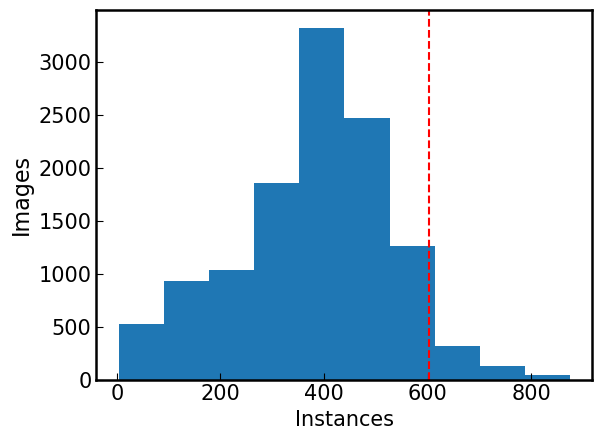

In [36]:
pcen = np.percentile(instances_list,95)
print(pcen)
plt.hist(instances_list)
plt.axvline(pcen,linestyle='--',color='r')
plt.xlabel('Instances',fontsize=15)
plt.ylabel('Images', fontsize=16)
plt.show()

### Custom image reader

In [10]:
def rescale_image(dataset_dict, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8, A=1e4):
    # Read image
    g = fits.getdata(os.path.join(dataset_dict['filename_G']), memmap=False)
    r = fits.getdata(os.path.join(dataset_dict['filename_R']), memmap=False)
    z = fits.getdata(os.path.join(dataset_dict['filename_I']), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        
        
        #max_RGB = np.nanpercentile([z, r, g], ceil_percentile) * 2
        max_RGB = np.nanpercentile([z, r, g], ceil_percentile)

        #max_RGB = np.max([g,r,z])


        # avoid saturation
        r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

        # Rescale to 0-255 for dtype=np.uint8
        max_dtype = np.iinfo(dtype).max
        r = r*max_dtype
        g = g*max_dtype
        z = z*max_dtype
        
        
    elif normalize.lower() == 'zscore':
        
        
        #Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        #z = (z - np.nanmean(z) - m)/Isigma
        # = (r - np.nanmean(r) - m)/Isigma
        #g = (g - np.nanmean(g) - m)/Isigma
        
        zsigma = np.nanstd(z)
        rsigma = np.nanstd(r)
        gsigma = np.nanstd(g)
        
        z = A*(z - np.nanmean(z) - m)/zsigma
        r = A*(r - np.nanmean(r) - m)/rsigma
        g = A*(g - np.nanmean(g) - m)/gsigma
        
        #max_RGB = np.nanpercentile([z, r, g], ceil_percentile) *2

        # avoid saturation
        #r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

        # Rescale to 0-255 for dtype=np.uint8
        #max_dtype = np.iinfo(dtype).max
        #r = r*max_dtype
        #g = g*max_dtype
        #z = z*max_dtype
        
        
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')



    # 0-255 RGB image
    image[:,:,0] = z # red
    image[:,:,1] = r # green
    image[:,:,2] = g # blue

    return image

### Visualize Normalization method
Lupton normalization behaves linear at low intensities, and log at high intensities \n
Goal is to find the parameters that optimize the normalization

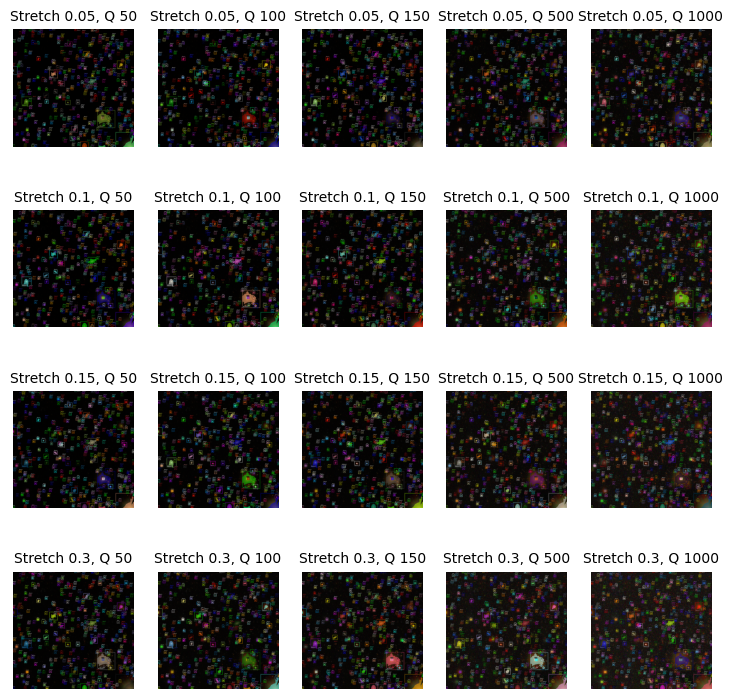

In [14]:
fig = plot_stretch_Q(dataset_dicts['train'], astrotrain_metadata, stretches = [0.05,0.1,0.15, 0.3],Qs=[50,100,150,500,1000], ceil_percentile=99.995)

threshold:  [ 0.01530371  0.01929197  0.0242363   0.03128944  0.04736865  0.09023234
  0.62051876 11.50211091]
std printed elinimates 0 value pixels
orig std:  1.7485281
normed std:  0.005170719


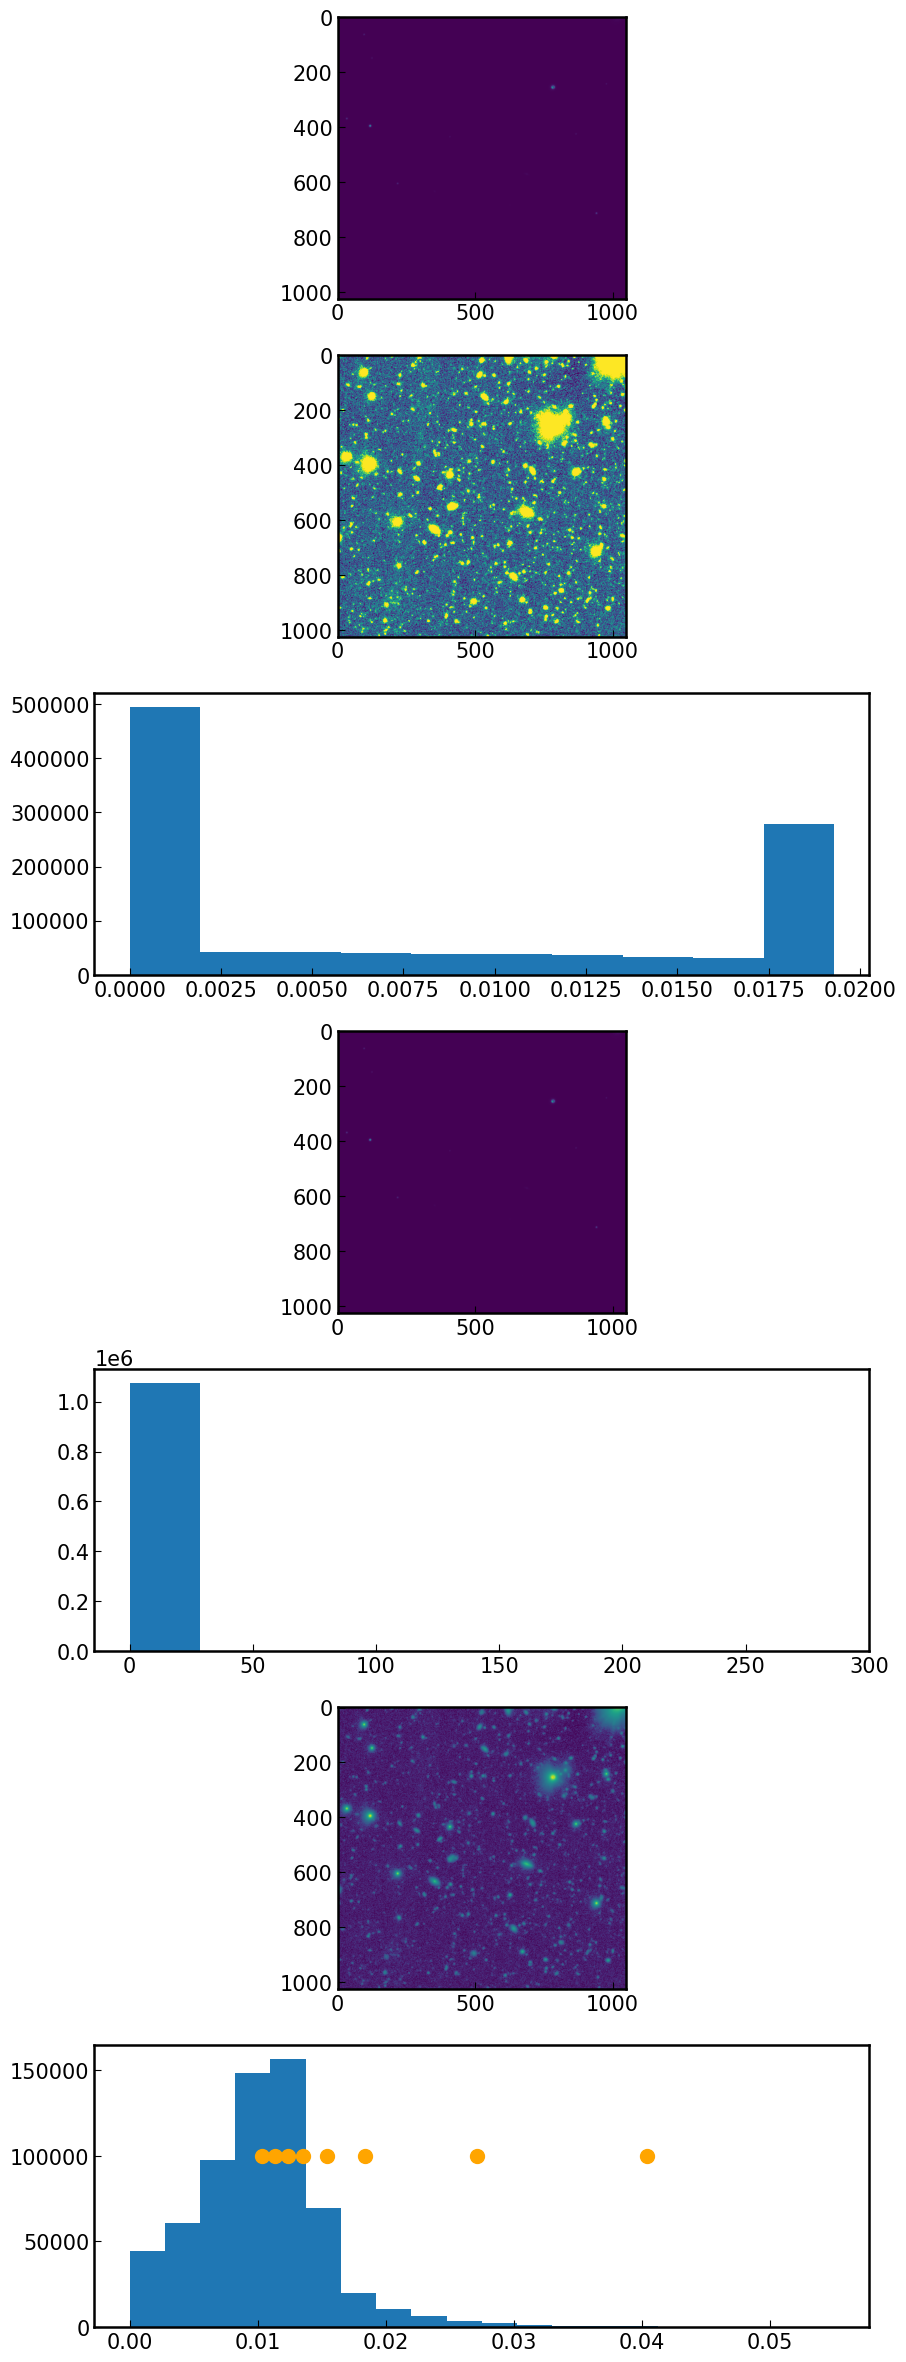

In [15]:
#test out normalization method
#yufeng april3 put stretch on the denominator in detectron.py
d = dataset_dicts['train'][0]
g = fits.getdata(os.path.join(d['filename_G']), memmap=False)
r = fits.getdata(os.path.join(d['filename_R']), memmap=False)
z = fits.getdata(os.path.join(d['filename_I']), memmap=False)
fig = plt.figure(figsize=(10,30))

#plot original
ax1 = plt.subplot(711)
g_zeropos = np.clip(g,0, np.max(g))
ax1.imshow(g_zeropos)

#plot linear part
g_pos_ind = np.where(g_zeropos.flatten()>0)
g_pos = g_zeropos.copy().flatten()[g_pos_ind]
g_threshold = np.percentile(g_pos, [50,60,70,80,90,95, 99, 99.9])
print('threshold: ', g_threshold)
threshold = g_threshold[1]
      
      
ax2 = plt.subplot(712)
g_low = np.clip(g_zeropos, np.min(g_pos), threshold)
ax2.imshow(g_low)
print('std printed elinimates 0 value pixels')
print('orig std: ', np.std(g_pos))

#plot histogram
ax3 = plt.subplot(713)
ax3.hist(g_low.flatten(), 10)

#plot log part
ax4 = plt.subplot(714)
g_high = np.clip(g_zeropos, threshold, np.max(g_zeropos))
ax4.imshow(g_high)

#plot histogram
ax5 = plt.subplot(715)
ax5.hist(g_high.flatten(), 10)

#plot normalized
q = 220
s = 0.7
g_normed = 1/q * np.arcsinh(q * g_zeropos.copy() / s)
ax6 = plt.subplot(716)
ax6.imshow(g_normed)

#plot histogram
threshold_normed = 1/q * np.arcsinh(q * g_threshold.copy() / s)
g_normed_pos_ind = np.where(g_normed>0)
g_normed_pos = g_normed[g_normed_pos_ind]
ax7 = plt.subplot(717)
ax7.hist(g_normed_pos.flatten(), 20)
ax7.scatter(threshold_normed, [100000,100000,100000,100000,100000,100000,100000,100000], s = 100, c='orange', zorder=3)
print('normed std: ', np.std(g_normed_pos))

### Visualize Ground Truth Examples

In [ ]:
nsample = 1
maxInd = sampleNumbers
if maxInd == -1: maxInd = 10
randInd = np.random.randint(0,maxInd, nsample)
fig = plt.figure(figsize=(30,30*nsample*2))
i = 0
for ind in randInd:
    # Need to increase ceil_percentile if the data are saturating!
    d = dataset_dicts['train'][ind]
    print(ind)
    img = read_image(d, normalize="lupton", stretch=.8, Q=150, ceil_percentile=99.9995)
    visualizer = Visualizer(img, metadata=astrotrain_metadata)
    out = visualizer.draw_dataset_dict(d)
    ax1 = plt.subplot(nsample*2, 1, 2*i+1)
    ax1.imshow(out.get_image(), origin='upper')
    ax1.axis('off')
    ax2 = plt.subplot(nsample*2, 1, 2*i+2)
    ax2.imshow(img)
    i += 1

-395.3325260770975 2138.6556014749744
-256.7262185941043 1542.2437091102036
-255.00527256235827 1408.503787076855


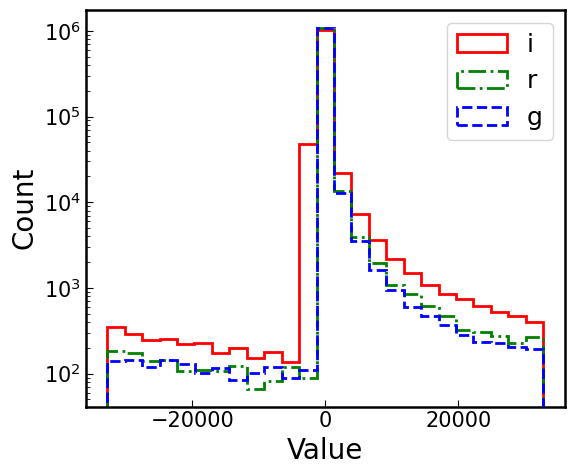

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
bins = 25
#91,28, 38 are  bad examples
d = dataset_dicts['train'][2]
img = rescale_image(d, normalize="zscore", stretch=.8, Q=150, ceil_percentile=99.9995,dtype=np.int16)
ax.hist(img[:,:,0].flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1, label='i');
ax.hist(img[:,:,1].flatten(), histtype="step", bins=bins, log=True, color="g", lw=2, linestyle='-.', zorder=2, label='r');
ax.hist(img[:,:,2].flatten(), histtype="step", bins=bins, log=True, color="b", lw=2, linestyle='dashed', zorder=3, label='g');
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
img = img.copy()
img0 = np.trim_zeros(img[:,:,0].flatten())
img1 = np.trim_zeros(img[:,:,1].flatten())
img2 = np.trim_zeros(img[:,:,2].flatten())
print(np.mean(img0), np.std(img0))
print(np.mean(img1), np.std(img1))
print(np.mean(img2), np.std(img2))
#yufeng apr20 get rid of mean > mean+std
ax.legend(fontsize=18)

fig.tight_layout()

In [76]:
means = np.zeros(3)
stds = np.zeros(3)
tl = len(dataset_dicts['train'])

m0=m1=m2=0
s0=s1=s2=0

for d in dataset_dicts['train']:
    img = rescale_image(d, normalize="zscore", stretch=5, Q=10, ceil_percentile=99.995,dtype=np.int16)
    m0+=img[:,:,0].mean()
    m1+=img[:,:,1].mean()
    m2+=img[:,:,2].mean()
    
    s0+=img[:,:,0].std()
    s1+=img[:,:,1].std()
    s2+=img[:,:,2].std()
    
means[0] = m0
means[1] = m1
means[2] = m2

stds[0] = s0
stds[1] = s1
stds[2] = s2
tl=len(dataset_dicts['train'])
print(means/tl)
print(stds/tl)

[-283.09874004 -238.71532866 -191.32925511]
[1673.00327372 1453.8772184  1191.24482461]


In [73]:
m1t

-4774.3065731390325

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


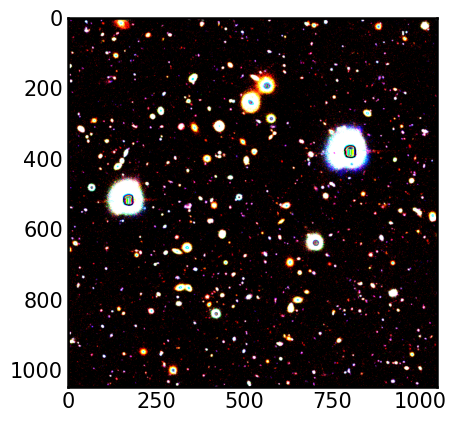

In [23]:
plt.imshow(img)

### Data Augmentation

In [11]:
from astrodet.astrodet import CustomAug
from detectron2.data.transforms.augmentation import KRandomAugmentationList

In [12]:

import imgaug.augmenters.flip as flip
import imgaug.augmenters.blur as blur


def hflip(image):
    return flip.fliplr(image)

#def gaussblur(image):
#    return blur.blur_gaussian_(image,sigma=np.random.random_sample()*4+2)

def gaussblur(image):
    aug = iaa.GaussianBlur(sigma=(0.0, np.random.random_sample()*4+2))
    return aug.augment_image(image)

def addelementwise16(image):
    aug = iaa.AddElementwise((-3276, 3276))
    return aug.augment_image(image)

def addelementwise8(image):
    aug = iaa.AddElementwise((-25, 25))
    return aug.augment_image(image)

In [13]:
def train_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
    image = rescale_image(dataset_dict, normalize="zscore", stretch=0.8, Q=150, ceil_percentile=99.995, dtype=np.int16)
    
    augs = KRandomAugmentationList([
        # my custom augs
        T.RandomRotation([-90, 90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.RandomFlip(prob=0.5,horizontal=False,vertical=True),
        CustomAug(gaussblur,prob=1.0),
        CustomAug(addelementwise8,prob=1.0)
        #CustomAug(white),
        ],
        k=-1
    )
    
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": image.shape[0],
        "width": image.shape[1],
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
    }

In [15]:
def test_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = rescale_image(dataset_dict, normalize="zscore", stretch=0.27, Q=150, ceil_percentile=99.995,dtype=np.int16)
    
    augs = T.AugmentationList([
        T.RandomCrop('relative',(0.5,0.5))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]


    instances = utils.annotations_to_instances(annos, image.shape[1:])
    instances = utils.filter_empty_instances(instances)

    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": image.shape[0],
        "width": image.shape[1],
        "image_id": dataset_dict["image_id"],
        "instances": instances,
        #"annotations": annos
    }


In [42]:
dictionary = iter(dataset_dicts['train'])


NameError: name 'rescale_image' is not defined

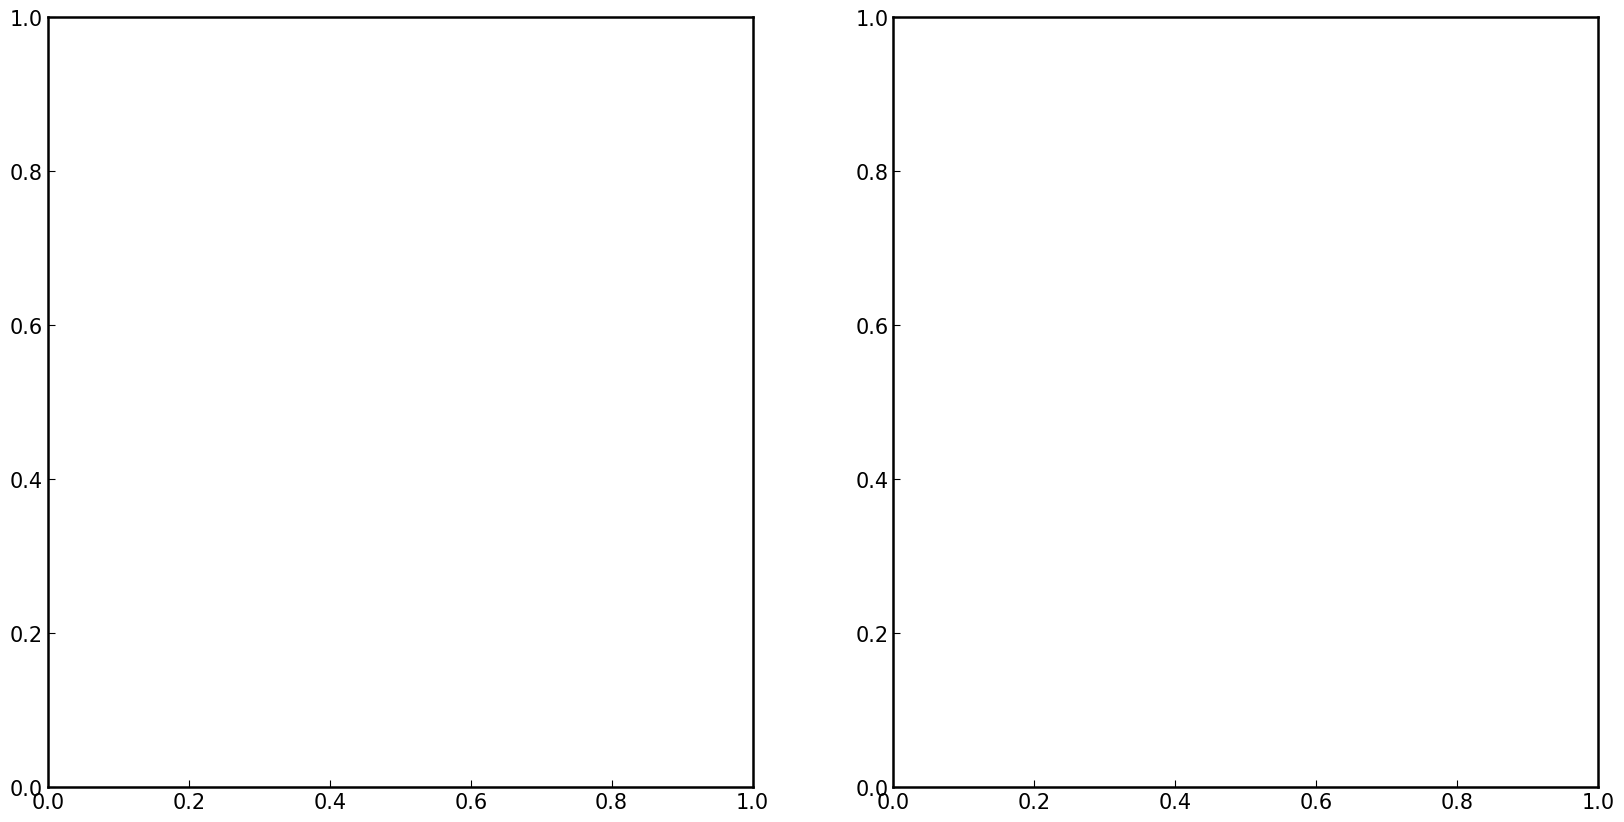

In [43]:
from detectron2.structures import BoxMode
fig, axs = plt.subplots(1,2, figsize=(10*2, 10))

#dictionary = iter(dataset_dicts['test_train'])
d = next(dictionary)
img = rescale_image(d, normalize="zscore", stretch=0.8, Q=150, ceil_percentile=99.995,dtype=np.int16)
visualizer = Visualizer(img, metadata=astrotrain_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a['bbox'] for a in d['annotations']])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis('off')

aug_d = train_mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astrotrain_metadata, scale=1)
print(img_aug.shape)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d['instances'].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis('off')
fig.tight_layout()
fig.show()

In [36]:
aug_d['instances'].gt_masks

PolygonMasks(num_instances=487)

### Training

In [40]:
import gc
gc.collect()


378

In [45]:
torch.cuda.empty_cache()
! nvidia-smi

Mon Jan  9 12:46:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000035:04:00.0 Off |                  Off |
| N/A   42C    P0    38W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

# Step 1)

init_coco_weights = True # Start training from MS COCO weights

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_train") # Register Metadata
cfg.DATASETS.TEST = ("astro_test") # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 0
cfg.DATALOADER.NUM_WORKERS = 1
if init_coco_weights:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")  # Initialize from MS COCO
else:
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, 'model_temp.pth')  # Initialize from a local weights
cfg.SOLVER.IMS_PER_BATCH = 4  # this is images per iteration. 1 epoch is len(images)/(ims_per_batch iterations*num_gpus)
cfg.SOLVER.BASE_LR = 0.001    
cfg.SOLVER.STEPS = []         # do not decay learning rate for retraining
cfg.SOLVER.MAX_ITER = 200     # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 250   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.PIXEL_MEAN = [-200,-200,-200]

cfg.MODEL.BACKBONE.FREEZE_AT = 4   # Initial re-training of the head layers (i.e. freeze the backbone)

cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]
cfg.INPUT.MIN_SIZE_TRAIN = 1025
cfg.INPUT.MAX_SIZE_TRAIN = 1050

cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
# Type of gradient clipping, currently 2 values are supported:
# - "value": the absolute values of elements of each gradients are clipped
# - "norm": the norm of the gradient for each parameter is clipped thus
#   affecting all elements in the parameter
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
# Maximum absolute value used for clipping gradients
# Floating point number p for L-p norm to be used with the "norm"
# gradient clipping type; for L-inf, please specify .inf
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 5.0
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg.SOLVER.WARMUP_ITERS = 0



cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
print(type(optimizer))

In [67]:
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)


[01/09 12:52:02 d2.data.build]: Removed 0 images with no usable annotations. 10 images left.
[01/09 12:52:02 d2.data.build]: Using training sampler TrainingSampler
[01/09 12:52:02 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[01/09 12:52:02 d2.data.common]: Serialized dataset takes 0.82 MiB


In [68]:
test_loader = data.build_detection_test_loader(cfg,cfg.DATASETS.TEST,mapper=test_mapper)

[01/09 12:52:04 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    star    | 416          |   galaxy   | 3385         |   other    | 199          |
|            |              |            |              |            |              |
|   total    | 4000         |            |              |            |              |
[01/09 12:52:04 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[01/09 12:52:04 d2.data.common]: Serialized dataset takes 0.72 MiB


In [69]:
tl=len(dataset_dicts['train'])
e1=int(tl/cfg.SOLVER.IMS_PER_BATCH*15)
e2=int(tl/cfg.SOLVER.IMS_PER_BATCH*10)
e3=int(tl/cfg.SOLVER.IMS_PER_BATCH*20)
efinal=int(tl/cfg.SOLVER.IMS_PER_BATCH*35)

print(e1,e2,e3,efinal)

37 25 50 87


In [70]:
# Hack if you get SSL certificate error 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [71]:
period=10
saveHook = toolkit.SaveHook()
schedulerHook = toolkit.CustomLRScheduler(optimizer=optimizer)
lossHook = toolkit.LossEvalHook(period, model, test_loader)
saveHook.set_output_name("test_hsc")
hookList = [lossHook,schedulerHook,saveHook]


In [74]:
trainer = toolkit.NewAstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(10) # print loss every 10 iterations
trainer.train(0,100)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (12, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[01/09 12:52:52 d2.engine.train_loop]: Starting training from iteration 0


/home/g4merz/.conda/envs/astrodetnv/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /scratch/env/opence1.5.1/conda-bld/pytorch-base_1643072044833/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration:  10  time:  3.520399332046509e-07  loss:  6.885728 val loss:  0 lr:  [0.001]
Iteration:  20  time:  2.989545464515686e-07  loss:  3.8258724 val loss:  8.334434331953526 lr:  [0.001]
Iteration:  30  time:  3.0174851417541504e-07  loss:  2.2637355 val loss:  3.6367701634764673 lr:  [0.001]
Iteration:  40  time:  2.9709190130233765e-07  loss:  2.1610699 val loss:  2.4792338848114013 lr:  [0.001]
Iteration:  50  time:  1.8998980522155762e-07  loss:  2.2187037 val loss:  2.125652815401554 lr:  [0.001]
Iteration:  60  time:  2.1513551473617554e-07  loss:  1.9885288 val loss:  2.06611660271883 lr:  [0.001]
Iteration:  70  time:  2.849847078323364e-07  loss:  1.9650251 val loss:  2.0276059873402117 lr:  [0.001]
Iteration:  80  time:  2.915039658546448e-07  loss:  1.8528719 val loss:  2.02599505931139 lr:  [0.001]
Iteration:  90  time:  2.39349901676178e-07  loss:  2.082613 val loss:  2.1222642242908476 lr:  [0.001]
Iteration:  100  time:  2.300366759300232e-07  loss:  1.9660298 val 

In [33]:
cfg.OUTPUT_DIR

'/home/shared/hsc/HSC/HSC_DR3/models/'

In [62]:
# Step 2)

cfg.MODEL.BACKBONE.FREEZE_AT = 0  # unfreeze all backbone layers  
cfg.SOLVER.BASE_LR = 0.0001   
#cfg.SOLVER.STEPS = [e2,e3]        # decay learning rate
cfg.SOLVER.STEPS = [500,1000]        # decay learning rate

cfg.SOLVER.MAX_ITER = efinal          # for DefaultTrainer
cfg.MODEL.WEIGHTS = os.path.join(output_dir, 'hsc_test.pth')  # Initialize from a local weights

model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)


[01/04 13:26:45 d2.data.build]: Removed 0 images with no usable annotations. 20 images left.
[01/04 13:26:45 d2.data.build]: Using training sampler TrainingSampler
[01/04 13:26:45 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[01/04 13:26:45 d2.data.common]: Serialized dataset takes 1.50 MiB


In [63]:
trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(20) # print loss every n iterations
trainer.train(0, 100)

[01/04 13:26:50 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                         | Shapes                                          |
|:------------------------------------------------|:--------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.res2.0.conv1.*                         | backbone.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.res2.0.conv2.*                         | backbone.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.res2.0.conv3.*                         | backbone.res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weig

[01/04 13:26:50 d2.engine.train_loop]: Starting training from iteration 0
Iteration:  20  time:  4.498288035392761e-07  loss:  tensor(1.8728, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  40  time:  2.998858690261841e-07  loss:  tensor(1.8489, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  60  time:  5.469191819429398e-07  loss:  tensor(1.9768, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  80  time:  2.8102658689022064e-07  loss:  tensor(1.8051, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  100  time:  3.1990930438041687e-07  loss:  tensor(1.6743, device='cuda:0', grad_fn=<AddBackward0>)


In [20]:
# Look at training curves in tensorboard:
#%load_ext tensorboard
#%tensorboard --logdir output --host localhost

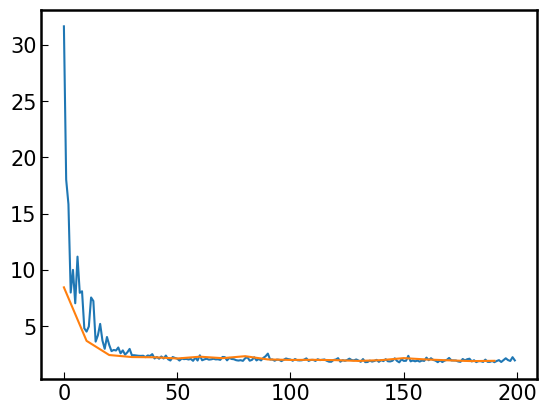

In [50]:
iters = np.arange(len(trainer.vallossList))*period

plt.plot(trainer.lossList)
plt.plot(iters,trainer.vallossList)

In [74]:
losses = np.load('/home/shared/hsc/HSC/HSC_DR3/models/test_losses.npy')
val_losses = np.load('/home/shared/hsc/HSC/HSC_DR3/models/test_val_losses.npy')

vperiod = np.ceil(len(losses)/len(val_losses))
iters = np.arange(len(val_losses))*vperiod
#print(vperiod)
l = len(dataset_dicts['train'])
print(len(losses))
print(l)

200
2000


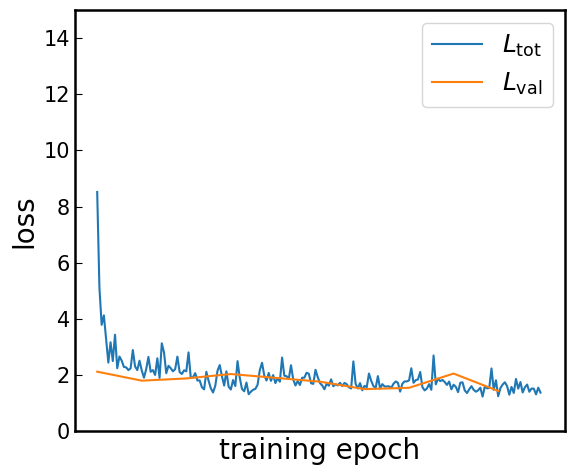

In [76]:
epochs = np.array([l/4*10,l/4*20,l/4*30,l/4*40,l/4*50])
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_xticks(epochs)
ax.set_xticklabels(['10','20','30','40','50'])
ax.set_xlim(-len(losses)*.05,len(losses)*1.05)
ax.set_ylim(0,15)

ax.plot(losses, label=r'$L_{\rm{tot}}$')
ax.plot(iters,val_losses, label=r'$L_{\rm{val}}$')

ax.legend(loc='upper right')
ax.set_xlabel('training epoch', fontsize=20)
ax.set_ylabel('loss', fontsize=20)
fig.tight_layout()

### Inference

In [77]:
import importlib
importlib.reload(toolkit)
from astrodet import astrodet as toolkit
toolkit.AstroPredictor

astrodet.astrodet.AstroPredictor

In [78]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_train") # Register Metadata
cfg.DATASETS.TEST = ("astro_val") # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
cfg.SOLVER.IMS_PER_BATCH = 4  # this is images per iteration. 1 epoch is len(images)/(ims_per_batch iterations*num_gpus)
cfg.SOLVER.BASE_LR = 0.001    
cfg.SOLVER.STEPS = []         # do not decay learning rate for retraining
cfg.SOLVER.MAX_ITER = 100     # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 250   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.MODEL.PIXEL_MEAN= [-200,-200,-200]
cfg.INPUT.MIN_SIZE_TRAIN = 1025
cfg.INPUT.MAX_SIZE_TRAIN = 1050

cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128]]

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "test.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
#predictor = DefaultPredictor(cfg)
predictor = toolkit.AstroPredictor(cfg)

[01/18 12:24:24 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [91]:
def test_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = rescale_image(dataset_dict, normalize="zscore", stretch=0.27, Q=150, ceil_percentile=99.995,dtype=np.int16)
    
    augs = T.AugmentationList([
        T.RandomCrop('relative',(0.5,0.5))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]


    instances = utils.annotations_to_instances(annos, image.shape[1:])
    instances = utils.filter_empty_instances(instances)

    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": image.shape[0],
        "width": image.shape[1],
        "image_id": dataset_dict["image_id"],
        "instances": instances,
        "annotations": annos
    }


total instances: 454
detected instances: 48



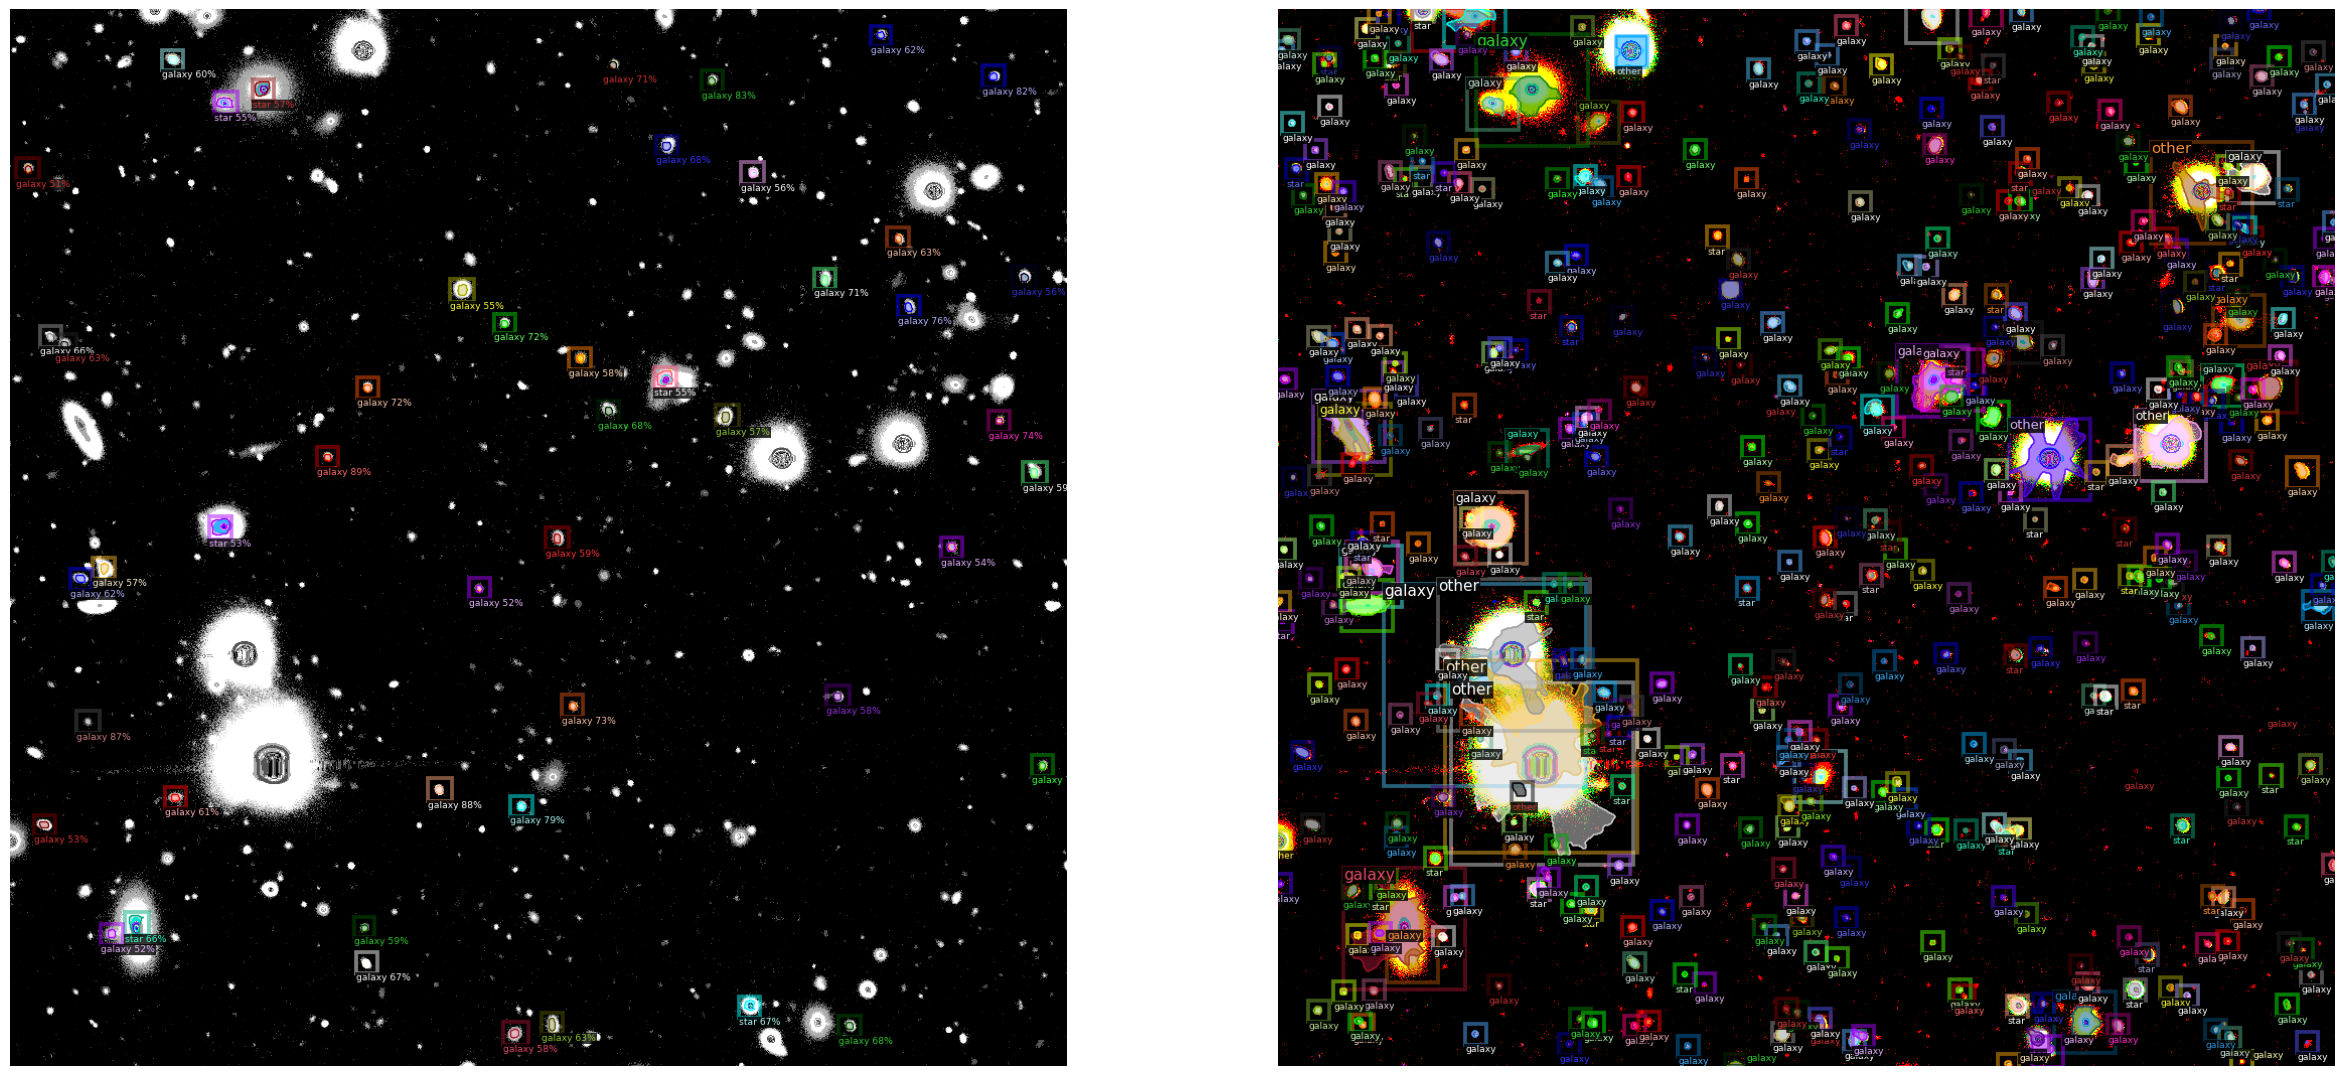

In [80]:
from detectron2.utils.visualizer import ColorMode

nsample = 1
fig = plt.figure(figsize=(30,15*nsample))

for i, d in enumerate(random.sample(dataset_dicts['test'], nsample)):
    img = rescale_image(d, normalize="zscore", stretch=0.8, Q=150, ceil_percentile=99.995, dtype=np.int16)
    print('total instances:', len(d['annotations']))
    v0 = Visualizer(img,
                   metadata=astrotest_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    groundTruth = v0.draw_dataset_dict(d)
    
    ax1 = plt.subplot(nsample, 2, 2*i+2)
    ax1.imshow(groundTruth.get_image())
    ax1.axis('off')
    
    v1 = Visualizer(img,
                   metadata=astrotest_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
    print('detected instances:', len(outputs['instances'].pred_boxes))
    print('')
    ax1 = plt.subplot(nsample,2,2*i+1)
    ax1.imshow(out.get_image())
    ax1.axis('off')
    

total instances: 112
detected instances: 41



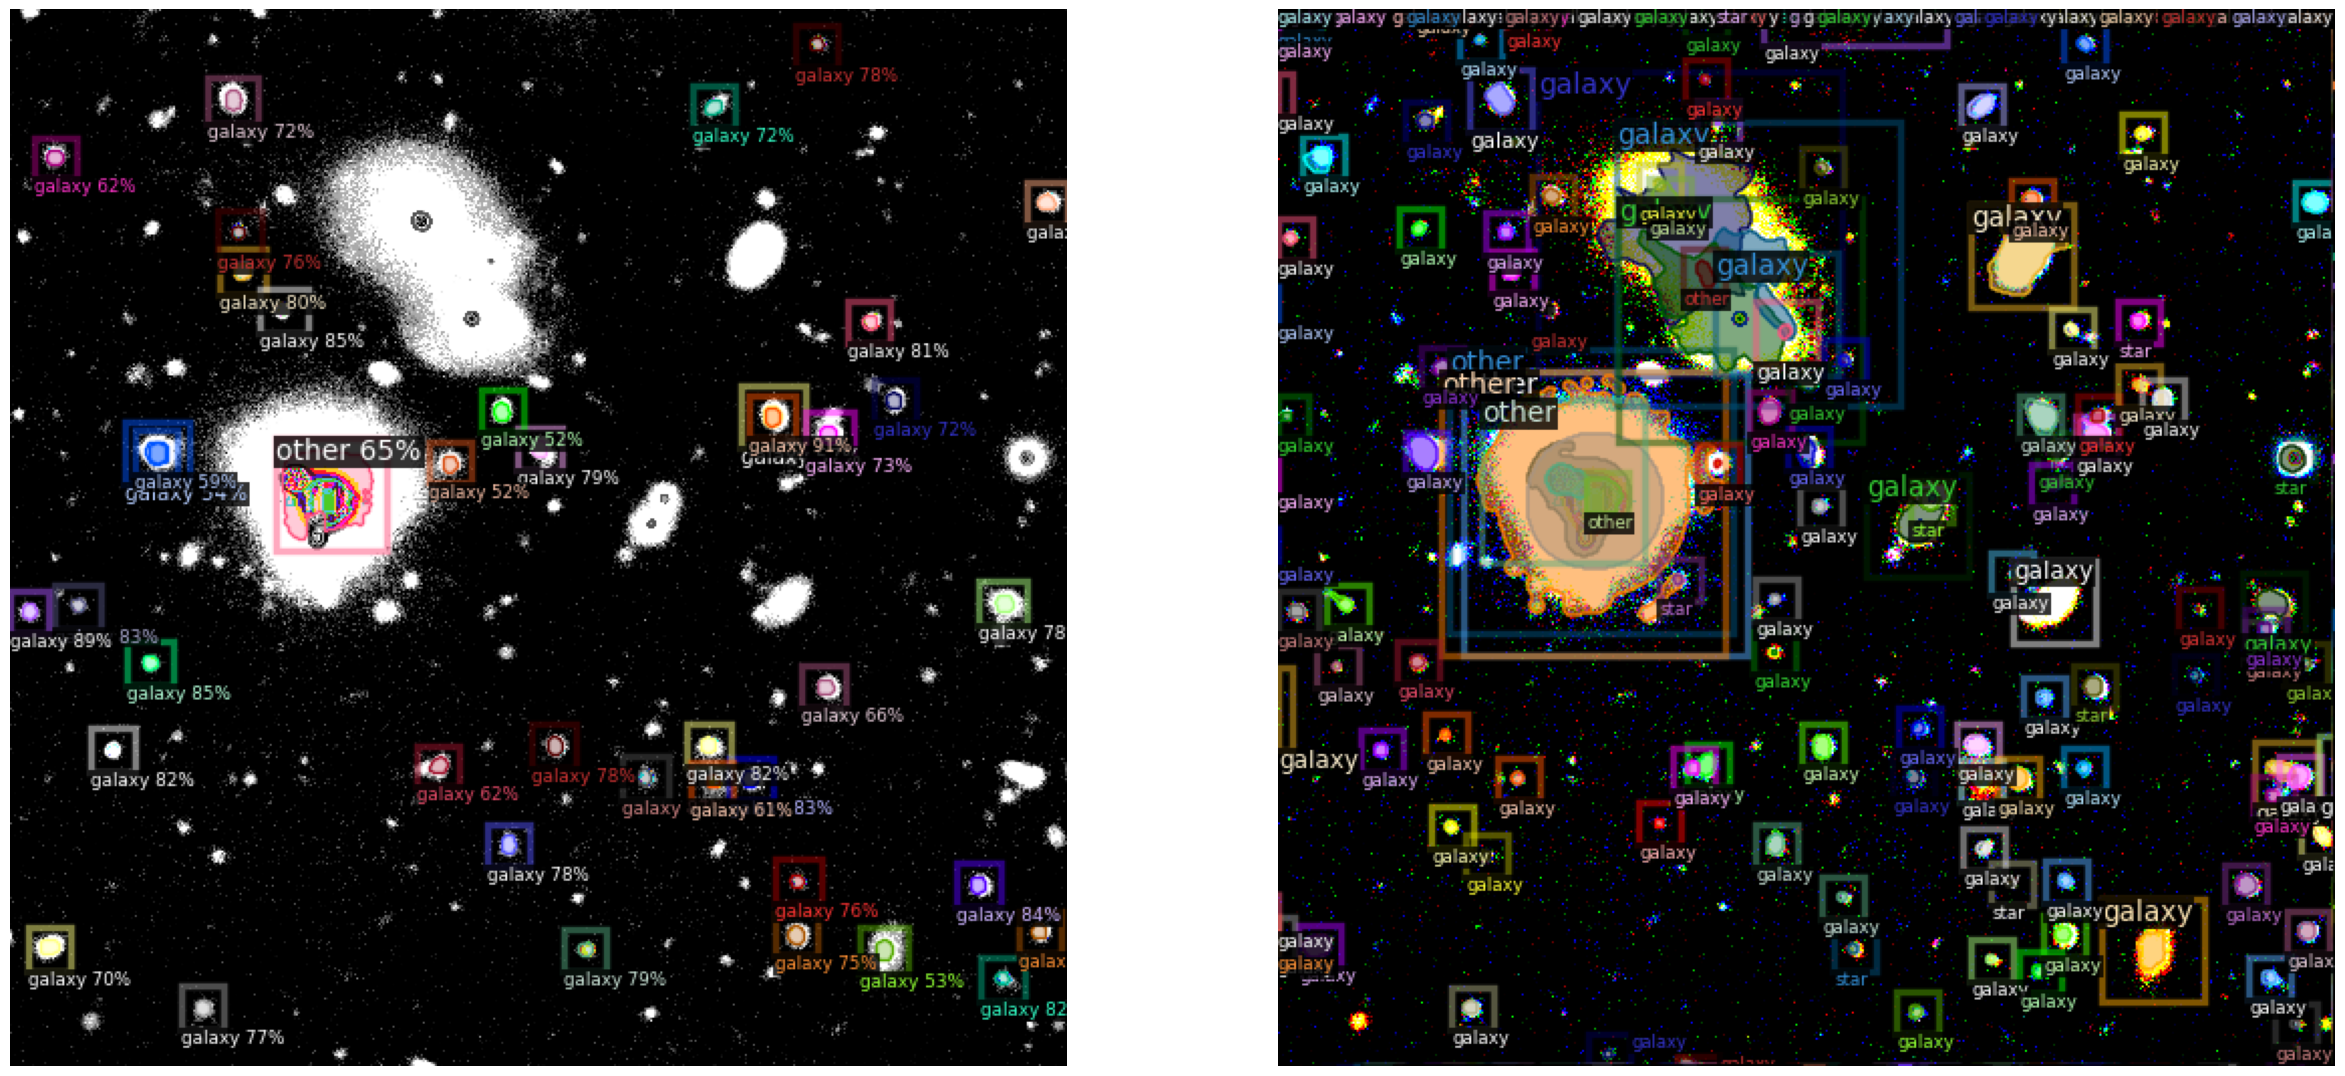

In [92]:
from detectron2.utils.visualizer import ColorMode

nsample = 1
fig = plt.figure(figsize=(30,15*nsample))

for i, d in enumerate(random.sample(dataset_dicts['test'], nsample)):
    
    cropped=test_mapper(d)

    img = cropped['image']
    img = img.numpy().transpose(1,2,0)
    
    #img = rescale_image(d, normalize="zscore", stretch=0.8, Q=150, ceil_percentile=99.995, dtype=np.int16)
    print('total instances:', len(cropped['instances']))
    v0 = Visualizer(img,
                   metadata=astrotest_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    
    
    
    
    groundTruth = v0.draw_dataset_dict(cropped)
    
    ax1 = plt.subplot(nsample, 2, 2*i+2)
    ax1.imshow(groundTruth.get_image())
    ax1.axis('off')
    
    v1 = Visualizer(img,
                   metadata=astrotest_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
    print('detected instances:', len(outputs['instances'].pred_boxes))
    print('')
    ax1 = plt.subplot(nsample,2,2*i+1)
    ax1.imshow(out.get_image())
    ax1.axis('off')
    

### Evaluate

NameError: name 'dataset_dict' is not defined

In [107]:
dd = copy.deepcopy(dataset_dicts['test'][0])  # it will be modified by code below

image = rescale_image(dd, normalize="zscore", stretch=0.27, Q=150, ceil_percentile=99.995,dtype=np.int16)

augs = T.AugmentationList([
    T.RandomCrop('relative',(0.5,0.5))
])
# Data Augmentation
auginput = T.AugInput(image, boxes=boxes, sem_seg=sem_seg)
# Transformations to model shapes
transform = augs(auginput)
image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
annos = [
    utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
    for annotation in dd.pop("annotations")
]


instances = utils.annotations_to_instances(annos, image.shape[1:])
instances = utils.filter_empty_instances(instances)

NameError: name 'boxes' is not defined

In [112]:
print(len(instances))
print(len(annos))
dataset_dicts['test'][0]


114
444


{'filename_G': '/home/shared/hsc/HSC/HSC_DR3/data/test/G-17131-7,3-c5_scarlet_img.fits',
 'filename_R': '/home/shared/hsc/HSC/HSC_DR3/data/test/R-17131-7,3-c5_scarlet_img.fits',
 'filename_I': '/home/shared/hsc/HSC/HSC_DR3/data/test/I-17131-7,3-c5_scarlet_img.fits',
 'file_name': '/home/shared/hsc/HSC/HSC_DR3/data/test/G-17131-7,3-c5_scarlet_img.fits',
 'image_id': 0,
 'height': 1050,
 'width': 1050,
 'annotations': [{'bbox': [158, -9, 21, 21],
   'area': 441,
   'bbox_mode': 1,
   'segmentation': [[166, 0, 166, 2, 167, 3, 169, 3, 170, 2, 170, 0]],
   'category_id': 1,
   'ellipse_pars': 'nan,nan,nan'},
  {'bbox': [1033, -8, 21, 21],
   'area': 441,
   'bbox_mode': 1,
   'segmentation': [[1039,
     0,
     1039,
     4,
     1040,
     5,
     1040,
     6,
     1041,
     7,
     1042,
     7,
     1043,
     8,
     1044,
     7,
     1045,
     7,
     1047,
     5,
     1047,
     0]],
   'category_id': 1,
   'ellipse_pars': '2.263950824737549,2.1870973110198975,-0.413662850856781

In [90]:
len(cropped['instances'])
len(cropped['annotations'])

419

#### Todo:  generate more test data, then perform evaluation with test data
#### Debug Tip: Delete the json and json.lock file in output folder before performaning evaluation

In [71]:
def eval_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = rescale_image(dataset_dict, normalize="zscore", stretch=0.27, Q=150, ceil_percentile=99.995,dtype=np.int16)
    
    augs = T.AugmentationList([
        #T.RandomCrop('relative',(0.5,0.5))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]


    instances = utils.annotations_to_instances(annos, image.shape[1:])
    instances = utils.filter_empty_instances(instances)

    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": image.shape[0],
        "width": image.shape[1],
        "image_id": dataset_dict["image_id"],
        "instances": instances,
        "annotations": annos
    }


In [72]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

# NOTE: New version has max_dets_per_image argument in default COCOEvaluator
evaluator = toolkit.COCOEvaluatorRecall("astro_test", use_fast_impl=True, output_dir=cfg.OUTPUT_DIR)

# First run with train_mapper to generate .json files consistent with training format
# Then run with test_mapper to get AP scores (doesn't work with augmentation mapper)
train_loader = build_detection_test_loader(dataset_dicts['test'][0:100], mapper=train_mapper)
test_loader = build_detection_test_loader(dataset_dicts['test'][0:100], mapper=eval_mapper)

[01/18 12:16:10 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[01/18 12:16:10 d2.data.common]: Serialized dataset takes 6.74 MiB
[01/18 12:16:10 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[01/18 12:16:10 d2.data.common]: Serialized dataset takes 6.74 MiB


In [73]:
try:
    # ignore ShapelyDeprecationWarning from fvcore
    from shapely.errors import ShapelyDeprecationWarning
    import warnings
    warnings.filterwarnings('ignore', category=ShapelyDeprecationWarning)
except:
    pass

results = inference_on_dataset(predictor.model, test_loader, evaluator)

[01/18 12:16:21 d2.evaluation.evaluator]: Start inference on 100 batches
[01/18 12:16:24 d2.evaluation.evaluator]: Inference done 11/100. Dataloading: 0.1527 s/iter. Inference: 0.0880 s/iter. Eval: 0.0079 s/iter. Total: 0.2486 s/iter. ETA=0:00:22
[01/18 12:16:31 d2.evaluation.evaluator]: Inference done 23/100. Dataloading: 0.3495 s/iter. Inference: 0.0872 s/iter. Eval: 0.0069 s/iter. Total: 0.4437 s/iter. ETA=0:00:34
[01/18 12:16:36 d2.evaluation.evaluator]: Inference done 42/100. Dataloading: 0.2608 s/iter. Inference: 0.0875 s/iter. Eval: 0.0073 s/iter. Total: 0.3557 s/iter. ETA=0:00:20
[01/18 12:16:41 d2.evaluation.evaluator]: Inference done 62/100. Dataloading: 0.2268 s/iter. Inference: 0.0875 s/iter. Eval: 0.0073 s/iter. Total: 0.3217 s/iter. ETA=0:00:12
[01/18 12:16:47 d2.evaluation.evaluator]: Inference done 83/100. Dataloading: 0.2075 s/iter. Inference: 0.0871 s/iter. Eval: 0.0072 s/iter. Total: 0.3019 s/iter. ETA=0:00:05
[01/18 12:16:50 d2.evaluation.evaluator]: Total inference

In [23]:
#print(results['bbox'])
#https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#detectron2.evaluation.inference_on_dataset
#https://detectron2.readthedocs.io/en/latest/modules/evaluation.html?highlight=COCOEvaluator#detectron2.evaluation.COCOEvaluator
#evaluate calls _eval_box_proposals(), which writes _results
#results_per category is in custom function?
print(results['bbox'].keys())
print(len(results['bbox']['results_per_category'][1]))

dict_keys(['AP', 'AP50', 'AP75', 'APs', 'APm', 'APl', 'results_per_category', 'AP-star', 'AP-galaxy'])
10


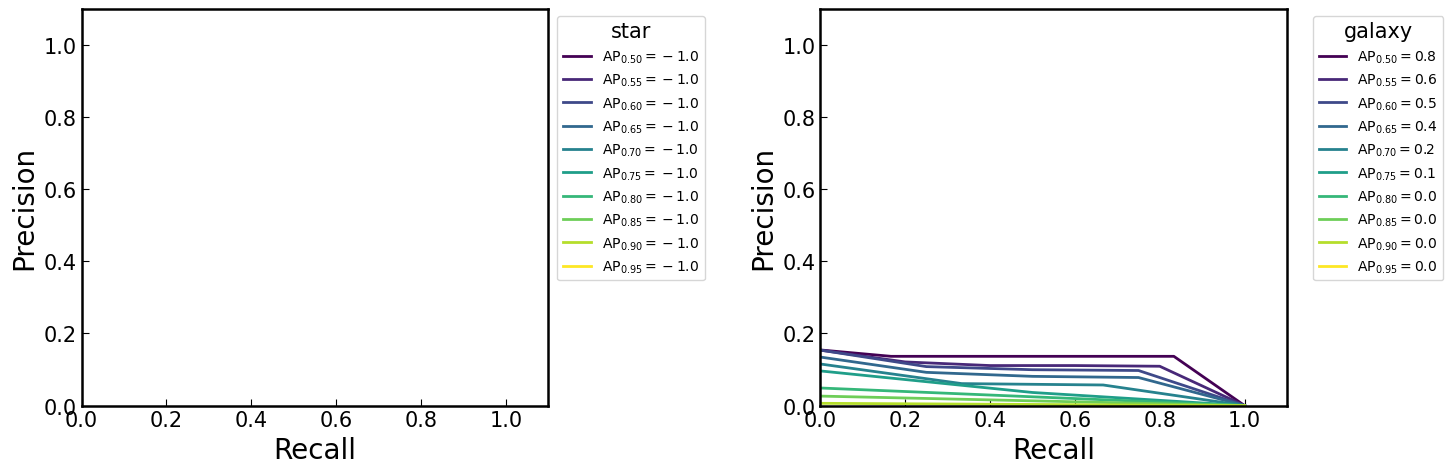

In [24]:
ap_type = 'bbox' # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ['star', 'galaxy']
#take star out april
results_per_category = results[ap_type]['results_per_category']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = (p_dat > 0)
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p)) # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0] # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100*np.sum(p*dr)
        axs[j].plot(r, p, label=r'${\rm{AP}}_{%.2f} = %.1f$' % (iou, AP), color=colors[i], lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f'{cls_names[j]}', bbox_to_anchor=(1.35, 1.0))
        
fig.tight_layout()